In [11]:
import numpy as np
import pandas as pd
import sklearn
import keras
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score,GridSearchCV,train_test_split
from sklearn.metrics import accuracy_score,roc_auc_score
from brew.base import Ensemble
from brew.stacking import EnsembleStackClassifier,EnsembleStack
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC,LinearSVR
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from util import *
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
train_data=pd.read_csv("raw/train.csv")
test_data=pd.read_csv("raw/test.csv")
Y=train_data.renewal
results=test_data[['id']].copy()
train_data.describe()

,id,perc_premium_paid_by_cash_credit,age_in_days,Income,Count_3-6_months_late,Count_6-12_months_late,Count_more_than_12_months_late,application_underwriting_score,no_of_premiums_paid,premium,renewal
count,79853.000000,79853.000000,79853.000000,7.985300e+04,79756.000000,79756.000000,79756.000000,76879.000000,79853.000000,79853.000000,79853.000000
mean,57167.166368,0.314288,18846.696906,2.088472e+05,0.248671,0.078188,0.060008,99.067291,10.863887,10924.507533,0.937410
std,32928.970160,0.334915,5208.719136,4.965826e+05,0.691468,0.436507,0.312023,0.739799,5.170687,9401.676542,0.242226
min,2.000000,0.000000,7670.000000,2.403000e+04,0.000000,0.000000,0.000000,91.900000,2.000000,1200.000000,0.000000
25%,28640.000000,0.034000,14974.000000,1.080100e+05,0.000000,0.000000,0.000000,98.810000,7.000000,5400.000000,1.000000
50%,57262.000000,0.167000,18625.000000,1.665600e+05,0.000000,0.000000,0.000000,99.210000,10.000000,7500.000000,1.000000
75%,85632.000000,0.538000,22636.000000,2.520900e+05,0.000000,0.000000,0.000000,99.540000,14.000000,13800.000000,1.000000
max,114076.000000,1.000000,37602.000000,9.026260e+07,13.000000,17.000000,11.000000,99.890000,60.000000,60000.000000,1.000000


In [3]:
# not_renew_cnt=train_data[train_data.renewal==0].shape[0]
# train_data=pd.concat([train_data[train_data.renewal==1].sample(not_renew_cnt),train_data[train_data.renewal==0]])
# Y=train_data.renewal
# train_data.shape

In [4]:
lbl_encoders={}
drop_cols=['id','renewal']
cate_cols=train_data.describe(include=['O']).columns
log_cols=['Income','premium']
for df in train_data,test_data:
    df.application_underwriting_score.fillna(90,inplace=True)
#     df.application_underwriting_score-=90
    df.fillna(0,inplace=True)
    
    for c in drop_cols:
        if c in df.columns:
            df.drop(c,axis=1,inplace=True)
    
    for c in cate_cols:
#         df[c]=df[c].astype('category')
        if c not in lbl_encoders:
            lbl_encoders[c]=LabelEncoder()
            lbl_encoders[c].fit(df[c])
        df[c]=lbl_encoders[c].transform(df[c])
        
#     for c in log_cols:
#         df[c]=df[c].map(np.log)
        
#     df['prem_total']=df.premium*df.no_of_premiums_paid
#     df['cash']=df.perc_premium_paid_by_cash_credit*df.premium
train_data.describe()

,perc_premium_paid_by_cash_credit,age_in_days,Income,Count_3-6_months_late,Count_6-12_months_late,Count_more_than_12_months_late,application_underwriting_score,no_of_premiums_paid,sourcing_channel,residence_area_type,premium
count,79853.000000,79853.000000,7.985300e+04,79853.000000,79853.000000,79853.000000,79853.000000,79853.000000,79853.000000,79853.000000,79853.000000
mean,0.314288,18846.696906,2.088472e+05,0.248369,0.078093,0.059935,98.729594,10.863887,0.822799,0.603396,10924.507533
std,0.334915,5208.719136,4.965826e+05,0.691102,0.436251,0.311840,1.864112,5.170687,1.052060,0.489195,9401.676542
min,0.000000,7670.000000,2.403000e+04,0.000000,0.000000,0.000000,90.000000,2.000000,0.000000,0.000000,1200.000000
25%,0.034000,14974.000000,1.080100e+05,0.000000,0.000000,0.000000,98.750000,7.000000,0.000000,0.000000,5400.000000
50%,0.167000,18625.000000,1.665600e+05,0.000000,0.000000,0.000000,99.180000,10.000000,0.000000,1.000000,7500.000000
75%,0.538000,22636.000000,2.520900e+05,0.000000,0.000000,0.000000,99.520000,14.000000,2.000000,1.000000,13800.000000
max,1.000000,37602.000000,9.026260e+07,13.000000,17.000000,11.000000,99.890000,60.000000,4.000000,1.000000,60000.000000


In [6]:
lgb = LGBMClassifier()
scores=cross_val_score(lgb,train_data,Y,scoring=score_auc2,cv=5,n_jobs=-1)
print(scores.mean(),scores.std())


0.8365684913689323 0.004115113851856034


In [244]:
lgb.fit(train_data,Y)
p=(lgb.predict_proba(test_data)[:,1]*100).astype('int')
p.shape[0],np.sum(p<80)/p.shape[0]

(34224, 0.07909654043945769)

In [243]:
np.sum(Y==0)/Y.shape[0]

0.06259000914179805

In [9]:
x_tra,x_dev,y_tra,y_dev=train_test_split(train_data,Y,test_size=0.1)

In [18]:
from keras.models import Sequential
from keras.layers import Dense,Activation,Dropout

model=Sequential([
    Dense(32, input_shape=(train_data.shape[1],),activation='tanh'),
    Dropout(0.6),
    Dense(1,activation='softmax')
])

model.summary()

model.compile(loss=keras.losses.binary_crossentropy,optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 32)                384       
_________________________________________________________________
dropout_6 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 33        
Total params: 417
Trainable params: 417
Non-trainable params: 0
_________________________________________________________________


In [19]:
model.fit(x_tra,y_tra,validation_data=(x_dev,y_dev),epochs=3)

Train on 71867 samples, validate on 7986 samples
Epoch 1/3
71867/71867 [==============================] - 3s 39us/step - loss: 0.9880 - acc: 0.9380 - val_loss: 1.0860 - val_acc: 0.9319
Epoch 2/3
71867/71867 [==============================] - 3s 35us/step - loss: 0.9880 - acc: 0.9380 - val_loss: 1.0860 - val_acc: 0.9319
Epoch 3/3
71867/71867 [==============================] - 2s 34us/step - loss: 0.9880 - acc: 0.9380 - val_loss: 1.0860 - val_acc: 0.9319


In [229]:
rf=RandomForestClassifier(n_estimators=200,max_depth=32,n_jobs=-1)
scores=cross_val_score(rf,train_data,Y,scoring='accuracy',cv=5,n_jobs=-1)
print(scores.mean(),scores.std())
# sorted(zip(X.columns,rf.feature_importances_),key=lambda x:x[1],reverse=True)

0.7547994994994995 0.006924078215575824


In [204]:
x_tra,x_dev,y_tra,y_dev=train_test_split(train_data,Y,test_size=0.1)
preds=np.zeros((y_dev.shape[0],2),dtype='int')
for i,c in enumerate(best_clfs[:2]):
    c.fit(x_tra,y_tra)
    preds[:,i]=c.predict(x_dev)


C:\apps\Anaconda2\envs\py3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [237]:
p1=y_dev[preds[:,0]!=y_dev]
p2=y_dev[preds[:,1]!=y_dev]
p1.shape[0],p2.shape[0],len(set(p1.index)&set(p2.index))
both_idx=set(p1.index)&set(p2.index)


In [240]:
not_renew_idx=Y.loc[both_idx][lambda y:y==0].index
wrong_probs=best_clfs[1].predict_proba(train_data.loc[not_renew_idx])[:,1]
pd.Series((wrong_probs*100).astype('int')).value_counts()

98    30
93    28
97    26
95    22
92    22
91    21
96    19
90    16
94    15
88    14
89    12
83    12
67    11
80    11
87    10
86    10
54    10
72    10
81     9
75     8
84     8
66     7
73     7
57     7
77     7
78     7
79     6
53     6
69     6
82     6
52     6
55     6
99     6
76     5
70     5
56     5
63     5
61     4
74     4
62     4
64     4
68     4
71     4
50     4
60     3
58     3
85     3
59     2
65     1
51     1
dtype: int64

In [213]:
train_data.describe()

,perc_premium_paid_by_cash_credit,age_in_days,Income,Count_3-6_months_late,Count_6-12_months_late,Count_more_than_12_months_late,application_underwriting_score,no_of_premiums_paid,sourcing_channel,residence_area_type,premium
count,79853.000000,79853.000000,7.985300e+04,79853.000000,79853.000000,79853.000000,79853.000000,79853.000000,79853.000000,79853.000000,79853.000000
mean,0.314288,18846.696906,2.088472e+05,0.248369,0.078093,0.059935,98.729594,10.863887,0.822799,0.603396,10924.507533
std,0.334915,5208.719136,4.965826e+05,0.691102,0.436251,0.311840,1.864112,5.170687,1.052060,0.489195,9401.676542
min,0.000000,7670.000000,2.403000e+04,0.000000,0.000000,0.000000,90.000000,2.000000,0.000000,0.000000,1200.000000
25%,0.034000,14974.000000,1.080100e+05,0.000000,0.000000,0.000000,98.750000,7.000000,0.000000,0.000000,5400.000000
50%,0.167000,18625.000000,1.665600e+05,0.000000,0.000000,0.000000,99.180000,10.000000,0.000000,1.000000,7500.000000
75%,0.538000,22636.000000,2.520900e+05,0.000000,0.000000,0.000000,99.520000,14.000000,2.000000,1.000000,13800.000000
max,1.000000,37602.000000,9.026260e+07,13.000000,17.000000,11.000000,99.890000,60.000000,4.000000,1.000000,60000.000000


In [51]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.metrics import roc_auc_score

tra_data=train_data.copy()
for c in cate_cols:
    tra_data[c]=tra_data[c].astype('category')

lgb2 = LGBMClassifier()
scores=cross_val_score(lgb2,tra_data,Y,scoring=score_auc,cv=5,n_jobs=-1)
print(scores.mean(),scores.std())
# sorted(zip(X.columns,lgb.feature_importances_),key=lambda x:x[1],reverse=True)

0.8391145257340702 0.004353159321039543


In [47]:
# from sklearn.svm import SVC,LinearSVC,LinearSVR

# svc=LinearSVR()
# svc.fit(x_tra,y_tra)
# print(accuracy_score(y_tra,svc.predict(x_tra)),accuracy_score(y_dev,svc.predict(x_dev)))

In [8]:
from sklearn.linear_model import LogisticRegression

lr=LogisticRegression()
lr.fit(x_tra,y_tra)
print(roc_auc_score(y_tra,lr.predict_proba(x_tra)[:,1]),roc_auc_score(y_dev,lr.predict_proba(x_dev)[:,1]))
sorted(zip(X.columns,lr.coef_.ravel()),key=lambda x:x[1],reverse=True)

0.6241289978308169 0.6233843609308618


[('application_underwriting_score', 0.001568736917663671),
 ('age_in_days', 0.0001260914280696475),
 ('no_of_premiums_paid', 4.228895613794295e-05),
 ('residence_area_type', 9.259656237019075e-06),
 ('premium', 8.639554727731608e-06),
 ('Income', 1.1064006133432162e-06),
 ('sourcing_channel', -1.3335017742726395e-05),
 ('perc_premium_paid_by_cash_credit', -4.5445214005235966e-05),
 ('Count_more_than_12_months_late', -5.38218879105637e-05),
 ('Count_6-12_months_late', -9.085771571849168e-05),
 ('Count_3-6_months_late', -0.00012613563718935516)]

In [193]:
base_clfs=[
#     LogisticRegression(),
#     SVC(probability=True),
#     KNeighborsClassifier(),
    RandomForestClassifier(),
#     GradientBoostingClassifier(),
#     AdaBoostClassifier(), 
#     ExtraTreesClassifier(), 
#     XGBClassifier(),
#     LGBMClassifier(),
]

[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.9s finished


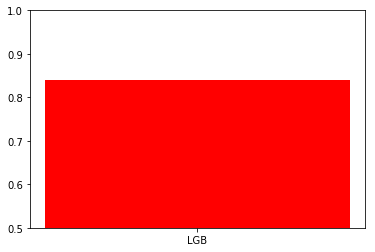

[('LGB', 0.8398176834305418)]


In [75]:



def trainModels(train_data, target):
    scores=[cross_val_score(clf,train_data,target,scoring=score_auc,cv=5,n_jobs=-1,verbose=1).mean() for clf in base_clfs]
    
    labels=[c.__class__.__name__[:3] for c in base_clfs]
    X=np.arange(len(base_clfs))
    plt.bar(X,scores,tick_label=labels,color='rgb')
    plt.ylim(0.5,1.0)
    plt.show()
    print(sorted(zip(labels,scores),key=lambda x:x[1],reverse=True))
    
trainModels(train_data,Y)

Help on class LGBMModel in module lightgbm.sklearn:

class LGBMModel(sklearn.base.BaseEstimator)
 |  Implementation of the scikit-learn API for LightGBM.
 |  
 |  Method resolution order:
 |      LGBMModel
 |      sklearn.base.BaseEstimator
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, boosting_type='gbdt', num_leaves=31, max_depth=-1, learning_rate=0.1, n_estimators=100, subsample_for_bin=200000, objective=None, class_weight=None, min_split_gain=0.0, min_child_weight=0.001, min_child_samples=20, subsample=1.0, subsample_freq=0, colsample_bytree=1.0, reg_alpha=0.0, reg_lambda=0.0, random_state=None, n_jobs=-1, silent=True, **kwargs)
 |      Construct a gradient boosting model.
 |      
 |      Parameters
 |      ----------
 |      boosting_type : string, optional (default="gbdt")
 |          'gbdt', traditional Gradient Boosting Decision Tree.
 |          'dart', Dropouts meet Multiple Additive Regression Trees.
 |          'goss', Gradient-based One-Si

In [194]:
# %%timeit
param_grid_set=[
#     {'C':[0.01,0.1,0.5,1.]},
#                 {'C':[1.,10.,],'kernel':['rbf','poly'],'gamma':[0.01,0.1,1.],'coef0':[1.,10.,]},
    {'n_estimators':[100,200,300],'max_depth':[8,16,32]},
                
#                 {'learning_rate':[0.01,0.1,1.0],'n_estimators':[100,200,300]},
#                 {'n_estimators':[50,100,200,300],'max_depth':[5,10,15]},
#     {'n_estimators':[100,200,300],'max_depth':[5,10,15],'gamma':[0.01,0.1,0.5]},
#     {'n_estimators':[100,200],
#      'learning_rate':[0.01,0.05,0.1],
#      'subsample':[1.,0.8],'colsample_bytree':[1.,0.8]
#     },
               ]

def tuneModels(train_data,target):
    results=[]
    for i in range(len(base_clfs)):
        gs=GridSearchCV(estimator=base_clfs[i],param_grid=param_grid_set[i],scoring=score_auc,n_jobs=-1,verbose=1,cv=5)
        gs.fit(train_data,target)
        results.append((gs.best_estimator_,gs.best_score_))
    print(sorted(results,key=lambda x:x[1],reverse=True))
    return results

tuned_r=tuneModels(train_data,Y)
best_clfs=[r[0] for r in tuned_r]

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:  3.6min finished


[(RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=8, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False), 0.8413666191210735)]


In [197]:
best_clfs=[RandomForestClassifier(n_estimators=200,max_depth=8,n_jobs=-1),
           LGBMClassifier(n_estimators=100,learning_rate=0.04,colsample_bytree=0.8),
           GradientBoostingClassifier(n_estimators=100,learning_rate=0.05)]

In [198]:
layer_1 = Ensemble(best_clfs)
layer_2 = Ensemble([LGBMClassifier()])

stack = EnsembleStack(cv=3)

stack.add_layer(layer_1)
stack.add_layer(layer_2)

sclf = EnsembleStackClassifier(stack)

x_tra,x_tst,y_tra,y_tst=train_test_split(train_data,Y,test_size=0.1)
sclf.fit(x_tra.values,y_tra.values)
print(roc_auc_score(y_tra,sclf.predict_proba(x_tra)[:,1]),roc_auc_score(y_tst,sclf.predict_proba(x_tst)[:,1]))
# scores=cross_val_score(sclf,train_data.values,Y,scoring=score_auc,cv=5,n_jobs=-1)
# print(scores.mean(),scores.std())


0.8530097094267832 0.8532954110810091


In [69]:
# %%timeit
x_tra,x_dev,y_tra,y_dev=train_test_split(train_data,Y,test_size=0.1)
preds=[]
for c in best_clfs:
    c.fit(x_tra,y_tra)
    preds.append(c.predict(x_tra))
lgb_en=LGBMClassifier()
lgb_en.fit(np.c_[preds].T,y_tra)

preds2=[]
for c in best_clfs:
    preds2.append(c.predict(x_dev))
print(roc_auc_score(y_dev,lgb_en.predict_proba(np.c_[preds2].T)[:,1]))

C:\apps\Anaconda2\envs\py3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\apps\Anaconda2\envs\py3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.5332432752688814


In [245]:
%%writefile util.py
from sklearn.metrics import roc_auc_score
def score_auc(c,x,y):
    p=c.predict_proba(x)[:,1]
    return roc_auc_score(y,p)

def score_auc2(c,x,y):
    p=c.predict_proba(x)[:,1]
    p[p<0.8]=0
    return roc_auc_score(y,p)

Overwriting util.py


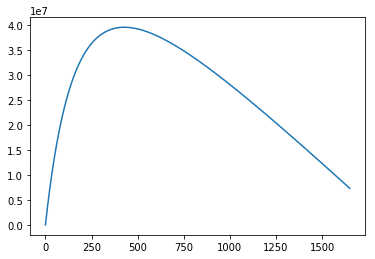

In [39]:

def inc_p(incentive):
    eff=10*(1-np.exp(-incentive/400))
    return 20*(1-np.exp(-eff/5))


def total_rev(premiums,incentives):
    return np.sum(np.multiply(inc_p(incentives)/100,premiums)-incentives)

t=[total_rev(test_data.premium,np.ones((test_data.shape[0],))*r) for r in range(1651)]
plt.plot(t)

In [40]:
np.argmax(t),total_rev(test_data.premium,np.ones((test_data.shape[0],))*np.argmax(t))

(428, 39582909.54636536)

In [41]:
def incentive_for_max_perm(prem):
    return np.argmax([inc_p(i)*prem/100 - i for i in range(1651)])
incentive_for_max_perm(10000)

409

In [42]:
# from tqdm import tnrange
# incentives=np.zeros((test_data.shape[0],))
# for i in tnrange(incentives.shape[0]):
#     incentives[i]=incentive_for_max_perm(test_data.iloc[i]['premium'])
# incentives[:3]

array([183., 446., 446.])

In [45]:
# np.save('incentive1',incentives)

In [201]:
best_clfs[0].fit(train_data.values,Y.values)
best_clfs[1].fit(train_data.values,Y.values)
results['renewal']=(best_clfs[0].predict_proba(test_data)[:,1]+best_clfs[1].predict_proba(test_data)[:,1])/2
results['incentives']=incentives.astype('int')

results.to_csv('submission/lgb_rf_div2.csv',index=False,float_format='%.6f')
!head submission/lgb_rf_div2.csv

id,renewal,incentives
649,0.991133,183
81136,0.981500,446
70762,0.780981,446
53935,0.975321,276
15476,0.955694,399
64797,0.983678,446
67412,0.831585,183
44241,0.821517,276
5069,0.990382,487


In [148]:
!head submission/lgb_tune.csv

id,renewal,incentives
649,0.99206,183
81136,0.98488,446
70762,0.79942,446
53935,0.97486,276
15476,0.96044,399
64797,0.98645,446
67412,0.83556,183
44241,0.78625,276
5069,0.99009,487


In [149]:
!head submission/lgb_deep_tuned.csv

id,renewal,incentives
649,0.993912,183
81136,0.981488,446
70762,0.745589,446
53935,0.973516,276
15476,0.964192,399
64797,0.986993,446
67412,0.824899,183
44241,0.782331,276
5069,0.993916,487
